In [1]:
# Clear memory
%reset -f

In [2]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import ipywidgets
ipywidgets.Widget.close_all()

import SimpleITK
import datetime
import gc # Garbage collected
import numpy as np
import sys, os
import time
import tifffile
import matplotlib.pyplot as plt
import scipy
from tkinter import Tk
from tkinter.filedialog import askopenfilename, askopenfilenames, askdirectory
import torch
import skimage
from skimage import measure

this_path = os.getcwd()
print(this_path)


import h5py
# import File
from scripts import *
import wrapper_ASTRA


/global/u2/e/eboigne/tomoTools_als832/tomoTools


In [3]:
path_save = '/global/homes/e/eboigne/cfs_als/2022_wood/'
case = 'run24_birch_lowHeat_test2'

In [6]:
ind_slice = 250

list_cases = sorted([e for e in os.listdir(path_save+case) if not 'probe' in e and not '.tif' in e])
print(list_cases)

slices = []
for ind_case, this_case in enumerate(list_cases[:-1]):
    slices.append(File(path_save+case+'/'+this_case+'/b_movingRegisteredToStatic/').read(ind_slice))
    print(ind_case, this_case)

slices = np.array(slices)
print(slices.shape)
File(path_save+case+'/probe_slice_'+str(ind_slice).zfill(4)).saveTiffStack(slices)

['01', '02', '03', '04', '05', '06', '07', '08a', '08b', '09a', '09b', '10a', '10b', '11a', '11b', '12a', '12b', '13a', '13b']
0 01
1 02
2 03
3 04
4 05
5 06
6 07
7 08a
8 08b
9 09a
10 09b
11 10a
12 10b
13 11a
14 11b
15 12a
16 12b
17 13a
(18, 1280, 1280)


In [5]:
scan_to_test = '09a'

# Load data
tic = time.time()
data = File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic/').readAll()
print('Loading data took: '+str(time.time()-tic))
print(data.shape)


Loading data took: 27.300331830978394
(698, 1280, 1280)


In [13]:
threshold = 0.05 # Linear attenuation threshold [/cm]
threshold_needle = 4.0 # Linear attenuation threshold [/cm]
mask_growth_needle = 10 # Grow the mask obtained using threshold_needle with this amount of pixels
mask_enclosing_circle = tifffile.imread(path_save+case+'/maskEnclosingCircle.tif') > 0

bin_factor_dilatation = 1 # Binning before smoothing, as an option to speed things up for large kernels
filter_half_width = 3 #  After binning (equal to sigma for gaussian filter)

# kernel = custom_3d_kernel_sphere(filter_half_width)
kernel = custom_3d_gaussian_filter(filter_half_width)
# filter_half_width = (kernel.shape[0]-1)/2

tic = time.time()
if bin_factor_dilatation > 1:
    data_smoothed = fast_pytorch_bin_3d(data,bin_factor_dilatation, chunk_size = 71)
else:
    data_smoothed = data

print(data_smoothed.shape)
data_smoothed = apply_3d_image_processing_on_subvolumes(data_smoothed, fast_pytorch_convolution, kernel_array = kernel, chunk_size_max = (500, 500, 500), overlap = 3*filter_half_width)
print(data_smoothed.shape)

if bin_factor_dilatation > 1:
    data_smoothed = skimage.transform.rescale(data_smoothed, bin_factor_dilatation, multichannel=False)
print('Smoothing data took: '+str(time.time()-tic))

# Save smoothed data
# File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_smoothed_bin'+str(bin_factor_dilatation)+'x_FHW_'+str(filter_half_width)).saveTiffStack(data_smoothed)

mask_needle = data_smoothed > threshold_needle
mask_needle = apply_3d_image_processing_on_subvolumes(mask_needle, fast_pytorch_mask_dilation, chunk_size_max = (500, 500, 500), overlap = mask_growth_needle, radius = mask_growth_needle)
# File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskNeedle').saveTiffStack(mask_needle, type = 'bool')

mask_solid = data_smoothed > threshold
mask_solid[mask_needle] = False
for ind, slice in enumerate(mask_solid):
    slice[~mask_enclosing_circle] = False
    mask_solid[ind] = slice
    if ind % 100 == 0:
        print(ind)

(698, 1280, 1280)
	 Processing 18 chunks of size [349 426 426] .................. Done
(698, 1280, 1280)
Smoothing data took: 29.117777347564697
	 Processing 18 chunks of size [349 426 426] .................. Done
0
100
200
300
400
500
600


In [14]:
File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskNeedle').saveTiffStack(mask_needle, type = 'bool')

In [8]:
ind_bottom = 100
ind_top = 610

mask_solid[:ind_bottom] = False
mask_solid[ind_top:] = False

	 Processing 18 chunks of size [349 426 426] .................. Done
1


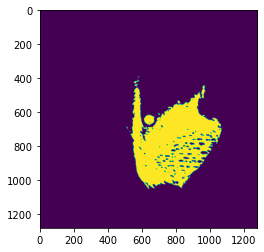

In [11]:
slice = mask_solid[ind_top-1]
plt.imshow(slice)

filter_half_width = 12
structure = custom_3d_kernel_sphere(filter_half_width)

tic = time.time()
# mask_solid_closed = scipy.ndimage.morphology.binary_closing(mask_solid, iterations = filter_half_width)
# mask_solid_closed = scipy.ndimage.morphology.binary_closing(mask_solid, structure = structure)

mask_solid_dilated = apply_3d_image_processing_on_subvolumes(mask_solid, fast_pytorch_mask_dilation, chunk_size_max = (500, 500, 500), overlap = filter_half_width, radius = filter_half_width)
print('1')
File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskSolidDilated').saveTiffStack(mask_solid_dilated, type = 'bool')

In [12]:
mask_solid_closed = ~apply_3d_image_processing_on_subvolumes(~mask_solid_dilated, fast_pytorch_mask_dilation, chunk_size_max = (500, 500, 500), overlap = filter_half_width, radius = filter_half_width)
print('Closing data took: '+str(time.time()-tic))

File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskSolidClosed').saveTiffStack(mask_solid_closed, type = 'bool')

	 Processing 18 chunks of size [349 426 426] .................. Done
Closing data took: 259.415002822876


In [10]:
# scipy.ndimage.binary_fill_holes()

In [ ]:

File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskSolid').saveTiffStack(mask_solid, type = 'bool')

In [55]:
tic = time.time()
lab = measure.label(~mask_solid)
print('Particle identification took: '+str(time.time()-tic))

Particle identification took: 14.235367774963379


In [56]:
File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskSolid_particleLabels').saveTiffStack(lab, type = 'bool')

In [57]:
tic = time.time()
properties = measure.regionprops(lab)
print('Particle analysis took: '+str(time.time()-tic))

Particle analysis took: 9.605185270309448


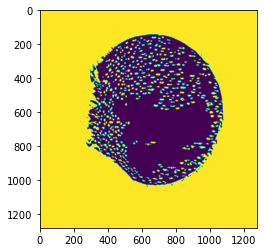

In [58]:
areas = [prop.area for prop in properties]

ind_max = np.argmax(areas)
prop_max_area = properties[ind_max]
mask_max_area = lab == prop_max_area.label

plt.imshow(mask_max_area[500], vmin = 0, vmax = 1)

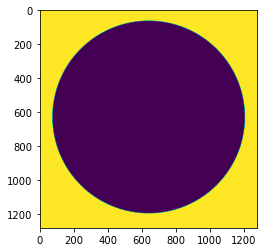

In [41]:
print(time.time())

1658280637.7989001
